In [1]:
%matplotlib inline

import os, glob, sys
import argparse
import numpy as np
import scipy as sp
import imageio
import string

import PIL.Image, PIL.ImageDraw, PIL.ImageFont

import matplotlib.pyplot as plt

import tensornetwork as tn

import random 
if hasattr(random,'choices'):
    choices = random.choices
else:
    def choices(seq,weights=None,k=1):
        if weights is None:
            return [random.choice(seq) for i in range(k)]
        else:
            weights = np.asarray(weights)
            cdf = np.cumsum(weights)
            np.insert(cdf,0,0)
            rnd = np.random.randint(cdf[-1],size=k)
            idx = np.digitize(rnd,cdf)
            return list(np.asarray(seq)[idx])

In [2]:
default_font = PIL.ImageFont.truetype('/usr/share/fonts/noto/NotoSans-Regular.ttf',12)
def render_text(txt,origin=(2,-1),size=(256,16),render_scale=1,font=default_font,bg=(0,0,0),fg=(255,255,255)):
    img = PIL.Image.new('RGB', (size[0]*render_scale,size[1]*render_scale), bg)
    draw = PIL.ImageDraw.Draw(img)
    draw.text((origin[0]*render_scale,origin[1]*render_scale), txt, fg, font=font)
    img = img.resize(size, PIL.Image.ANTIALIAS)
    return np.asarray(img.getdata()).reshape((size[1],size[0],3))

In [3]:
def char_boundaries(txt,font):
    return np.asarray([(s:= font.font.getsize(txt[:i]))[0][0]+s[1][0] for i in range(len(txt))])

def chunks(width,chunking=24,stride=5):
    return [(i,i+chunking) for i in range(0,width-chunking,stride)]

def chunk(img,slices):
    return [img[:,l:r,:] for l,r in slices] 

def chunk_and_tag(txt,font=default_font,width=512,height=16,chunking=24,stride=5):
    txt = txt.strip()+' '#conditioning
    offset = 2+np.random.randint(-1,2)
    img = render_text(txt,origin=(offset,-1),size=(width,height),font=font)
    boundaries = char_boundaries(txt,font)+font.font.getsize(txt[0])[1][0]+offset
    slices = chunks(width,chunking=chunking,stride=stride)
    text_masks = [np.logical_and(left+1 <= boundaries, boundaries <= right-1) for left,right in slices]
    txt = np.asarray(list(txt))
    tags = [txt[(np.where(mask)[0][:-1],)] for mask in text_masks]
    bounds = [[j for j in boundaries-i if j >= 1 and j < chunking-1] for i in range(0,img.shape[1]-chunking,stride)]
    bounds = [b for b in bounds if len(b) > 1]
    return tags,bounds,chunk(img,slices)

def gen_tagged_data(txt,**kwargs):
    tags,bounds,imgs = chunk_and_tag(txt,**kwargs)
    yield from ((tag,bound,img) for tag,bound,img in zip(tags,bounds,imgs) if len(tag)>0)
    
def gen_char_batch(tag,bound,img,pad_width=16):
    left = lambda j: bound[j]+np.random.randint(-1,2)-1
    right = lambda j,l: (bound[j+1]+np.random.randint(-1,1)+1 if np.random.random()<0.95 else l+pad_width)
    glyph = [img[:,(l:=left(j)):right(j,l),:] for j in range(len(bound)-1)]
    glyph = [np.pad(g,pad_width=((0,0),(0,pad_width-g.shape[1]),(0,0)),mode='constant', constant_values=0) for g in glyph]
    yield from zip(tag,glyph)
    
def gen_data(txt,**kwargs):
    gen_it = (gen_char_batch(*chunk) for chunk in gen_tagged_data(txt,**kwargs))
    for gen in gen_it:
        yield from gen

In [4]:
approx_freq = {' ':1000,'!':200,',':200,'.':200,'?':200,'A':29,'B':3,'C':16,'D':18,'E':37,'F':3,'G':3,'H':3,
               'I':42,'J':14,'K':13,'L':21,'M':17,'N':24,'O':29,'P':11,'Q':5,'R':22,'S':18,'T':32,'U':28,
               'V':3,'W':3,'X':3,'Y':3,'Z':2,'a':29,'b':3,'c':16,'d':18,'e':37,'f':3,'g':3,'h':3,'i':42,
               'j':14,'k':13,'l':21,'m':17,'n':24,'o':29,'p':11,'q':5,'r':22,'s':18,'t':32,'u':28,'v':3,
               'w':3,'x':3,'y':3,'z':2}
letters = np.asarray(list(string.ascii_letters+string.punctuation+string.digits+' '))
for letter in letters:
    if letter not in approx_freq:
        approx_freq[letter] = 10
for letter in string.ascii_lowercase:
    approx_freq[letter] *=  10

def speach_like(i,j):
    vals = np.asarray(list(approx_freq.keys()))
    w = np.asarray(list(approx_freq.values()))
    txt_block = np.asarray(choices(vals,weights=w,k=i*j)).reshape((i,j))
    return txt_block

letters

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',
       '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^',
       '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', ' '], dtype='<U1')

In [5]:
generated = list(map(lambda x: ''.join(x), speach_like(5,50)))
generated

[' ?js i!pp,6  .q |!i n !!n j u dl.en o nupuj dRtud ',
 'eui ?,n csiiek,!yuqegi,o e Iiat rk?llI?ridOald lle',
 'jitlinv_?DDe!aldini.pog`u  l!psnik!s  ekcntk. }iu,',
 '5 m.e !d m. igl p  liIiee??t !e.u kdem,iR,yi ezrie',
 'e,in!mityj3e!uvraq.e !ntnt!2jlskzibiaatac`da!Is t?']

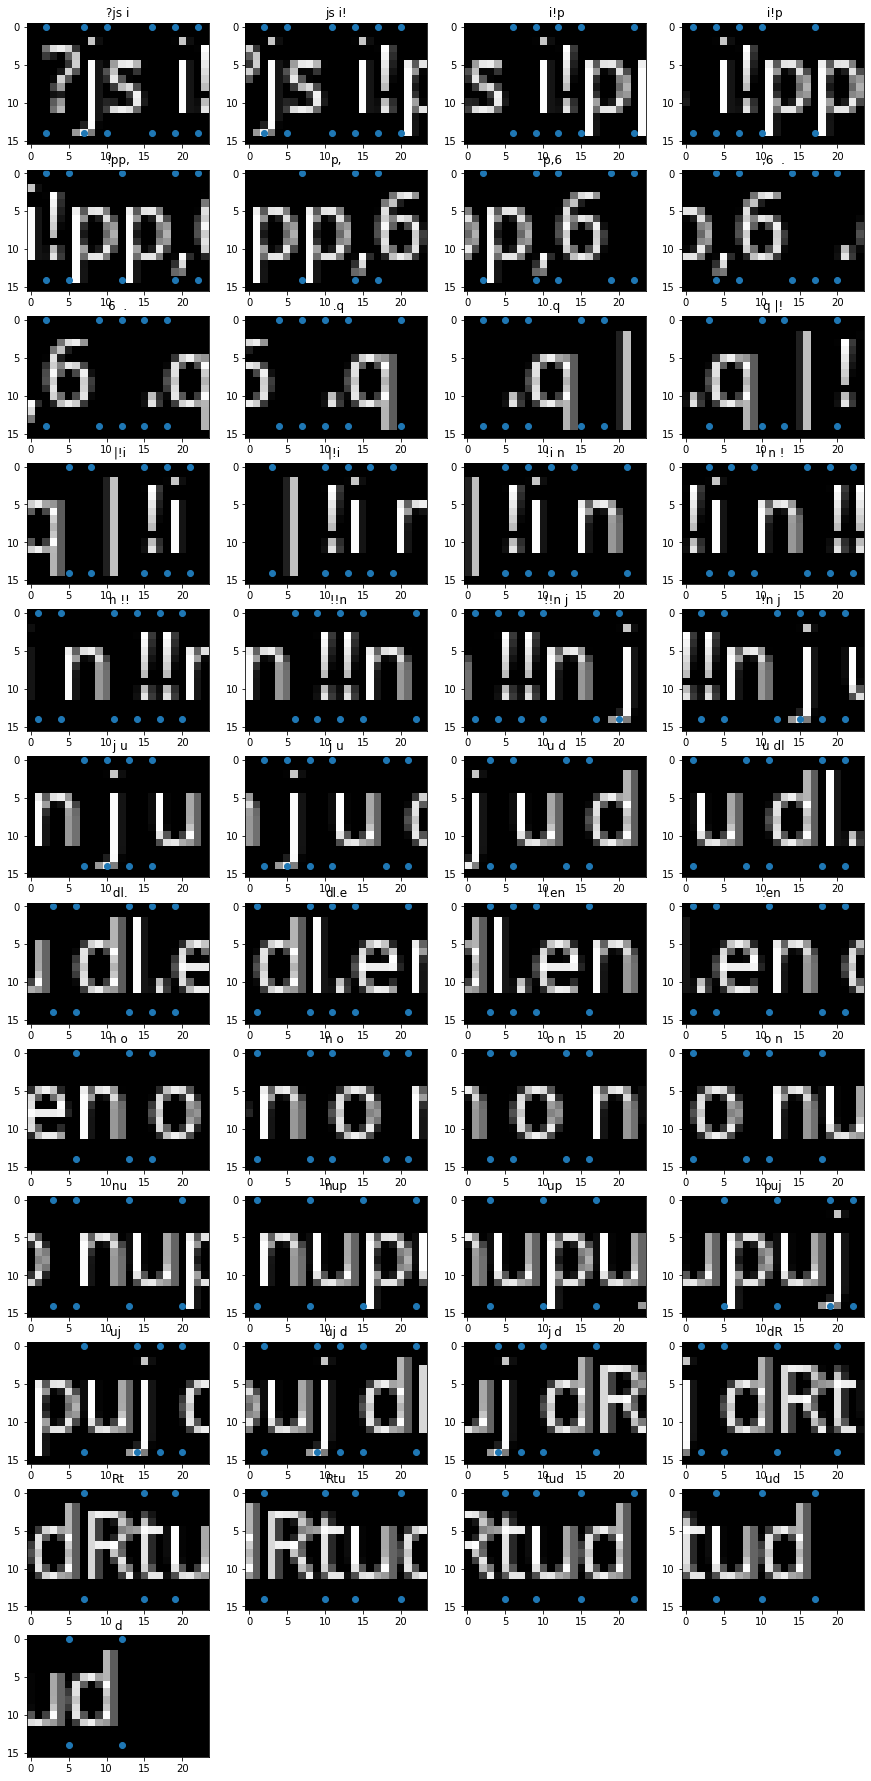

In [6]:
txt = generated[0]
tags,bounds,imgs = chunk_and_tag(txt,width=320)

fig = plt.figure(figsize=[15,40])
for i,(tag,bound,img) in enumerate(zip(tags,bounds,imgs)):
    ax = fig.add_subplot((len(imgs)+3)//4,4,1+i)
    ax.set_title(''.join(tag))
    plt.imshow(imgs[i])
    plt.scatter([[b,b] for b in bound],[0,14]*len(bound))
plt.close(fig)
fig

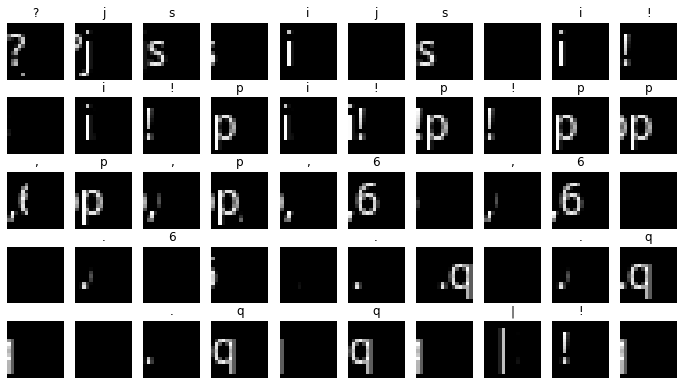

In [7]:
fig = plt.figure(figsize=[12,8])
maxnum = 50
for i,(tag,glyph) in enumerate(gen_data(txt)):
    if i >= maxnum:
        break
    ax = fig.add_subplot(maxnum//10+1,10,i+1)
    ax.set_title(tag)
    plt.imshow(glyph)
    plt.axis('off')
    

In [8]:
def get_split_model(width=24,height=16,channels=3,features=[((3,3),2),((2,14),8)],lstm_depth=0,lstm_space=10,dense_depth=1,dense_space=1000):
    img_input = tn.Input(shape=(width,height,channels))()
    prev_layer = img_input
    
    conv_layers = []
    for i,(shape,num) in enumerate(features):
        prev_layer = tn.Conv(shape, kernel_stride=(1,1), out_shape=(num,), pad=False, activation=tn.ReLU())(prev_layer)
        conv_layers.append(prev_layer)
        
    lstm_layers = []
    for i in range(lstm_depth):
        prev_layer = tn.LSTM(lstm_space, go_backwards=(i%2!=0))(prev_layer)
        lstm_layers.append(prev_layer)
        
    dense_layers = []
    for i in range(dense_depth):
        prev_layer = tn.Dense(dense_space, activation=tn.Tanh())(prev_layer)
        dense_layers.append(prev_layer)
        
    output = tn.Dense(width, activation=tn.Sigmoid())(prev_layer)
    return tn.System(inputs=[img_input], outputs=[output])
    
def get_char_model(width=16,height=16,channels=3,features=[((3,3),2)],lstm_depth=0,lstm_space=10,dense_depth=1,dense_space=5000,categories=len(letters)):
    img_input = tn.Input(shape=(width,height,channels))()
    prev_layer = img_input
    
    conv_layers = []
    for i,(shape,num) in enumerate(features):
        prev_layer = tn.Conv(shape, kernel_stride=(1,1), out_shape=(num,), pad=False, activation=tn.ReLU())(prev_layer)
        conv_layers.append(prev_layer)
                
    lstm_layers = []
    for i in range(lstm_depth):
        prev_layer = tn.LSTM(lstm_space, go_backwards=(i%2!=0))(prev_layer)
        lstm_layers.append(prev_layer)
        
    dense_layers = []
    for i in range(dense_depth):
        prev_layer = tn.Dense(dense_space, activation=tn.Tanh())(prev_layer)
        dense_layers.append(prev_layer)
    
    output = tn.Dense(categories, activation=tn.Sigmoid())(prev_layer) #softmax
    return tn.System(inputs=[img_input], outputs=[output])

In [9]:
smodel = get_split_model()
smodel_name = 'nono_split6.h5'
if os.path.exists(smodel_name):
    smodel.load_weights(smodel_name)

cmodel = get_char_model()
cmodel_name = 'noto_char6.h5'
if os.path.exists(cmodel_name):
    cmodel.load_weights(cmodel_name)
    
def checkpoint():
    smodel.save_weights(smodel_name)
    cmodel.save_weights(cmodel_name)

In [10]:
#checkpoint()

In [11]:
def train_char_model(cycles=100):
    success = 0
    trials = 0
    random_arrays = speach_like(1000,75)
    for txt in (''.join(x) for x in random_arrays):
        for tag,glyph in gen_data(txt):
            input = np.swapaxes(glyph,0,1)/255
            true_out = np.asarray(letters == tag,dtype='float64')
            trials += 1
            guess_out,state = cmodel.guess([input],return_state=True)
            if np.argmax(guess_out[0]) == np.argmax(true_out):
                success += 1
            cmodel.learn(state,[true_out],loss='ce',method='adam',scale=0.0001)
            if trials >= cycles:
                break
        else:
            continue
        break
    print(success,'/',trials)
    return success,trials

In [12]:
def train_split_model(cycles=1000):
    success = 0
    trials = 0
    false_positives = 0
    false_negatives = 0
    true_total = 0
    random_arrays = speach_like(cycles,50)
    for txt in (''.join(x) for x in random_arrays):
        for tag,bound,img in gen_tagged_data(txt,width=400,chunking=24,stride=5):
            input = np.swapaxes(img,0,1)/255
            true_out = np.zeros((24,))
            true_out[bound] = 1
            trials += 1
            guess_out,state = smodel.guess([input],return_state=True)
            delta = np.asarray(guess_out[0]>0.7,dtype=np.int32) - np.asarray(true_out>0.7,dtype=np.int32)
            false_positives += np.count_nonzero(delta == 1)
            false_negatives += np.count_nonzero(delta == -1)
            true_total += np.count_nonzero(delta == 0)
            if np.all((guess_out[0]>0.7) == (true_out>0.7)):
                success += 1
            smodel.learn(state,[true_out],loss='ce',method='adam',scale=0.001)
            if trials >= cycles:
                break
        else:
            continue
        break
    print(success,'/',trials)
    print('FN:',false_negatives,'FP:',false_positives,'Correct:',true_total)
    return success,trials

In [ ]:
try:
    while True:
        print('character model segment')
        train_char_model()
        print('split model segment')
        train_split_model()
        checkpoint()
except KeyboardInterrupt:
    pass

In [14]:
def guess_characters(img,threshold=0.95,chunking=24,stride=5,make_plots=False):
    imgs = list(chunk(img,chunks(img.shape[1],chunking=chunking,stride=stride)))
    i = 0
    detected = []
    weights = []
    last_boundidx = np.asarray([],dtype=np.int32)
    for i,img in enumerate(imgs):
        snn_in = np.swapaxes(img,0,1)/255
        snn_out = smodel.guess([snn_in])[0]
        bound = snn_out > threshold
        sweight = snn_out[bound]

        boundidx = np.nonzero(bound)[0]
        if len(last_boundidx) > 0:
            mask = boundidx >= last_boundidx[-1]
            boundidx = boundidx[mask]
        
        if len(boundidx) > 1:
            last_boundidx = boundidx
            glyphs = [img[:,boundidx[j]-1:boundidx[j+1]+1,:] for j in range(len(boundidx)-1)]
            glyphs = [g[:,:min(16,g.shape[1]),:] for g in glyphs]
            glyphs = [np.pad(g,pad_width=((0,0),(0,16-g.shape[1]),(0,0)),mode='constant', constant_values=0) for g in glyphs]

            inputs_list = [[np.swapaxes(g,0,1)/255] for g in glyphs]
            cnn_out = np.asarray([cmodel.guess(inputs)[0] for inputs in inputs_list])
            chars = np.argmax(cnn_out,axis=1)
            cweights = np.max(cnn_out,axis=1)

            chars = letters[chars]
            detected.extend(chars)
            weights.extend(cweights)
        else:
            chars,weights = [],[]
        last_boundidx = last_boundidx - stride
        
        if make_plots:
            if i%5==0:
                if i>0:
                    plt.show()
                    plt.close()
                plt.figure(figsize=(15,3))
            plt.subplot(1,5,i%5+1)
            plt.title(' '.join(['\'%s\'(%s)'%(c,p) for c,p in zip(chars,['%.02f'%w for w in cweights])]))
            xval = np.arange(-1,len(bound))-0.5
            yval = np.concatenate([[16],16-16*bound])
            plt.fill(xval,yval,'r',alpha=0.5)
            plt.imshow(img)
            plt.axis('off')
    if make_plots:
        plt.show()
        plt.close()
    out = ''.join([c for c in detected])
    return out

In [15]:
def test(txt,verbose=False):
    print('txt:',txt)
    img = render_text(txt,origin=(3,-1),size=(200,16),font=default_font)
    plt.imshow(img)
    plt.show()
    plt.close()
    out = guess_characters(img,make_plots=verbose)
    print('out:',out)

txt: Hello i am dog~ woof woof!


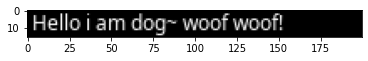

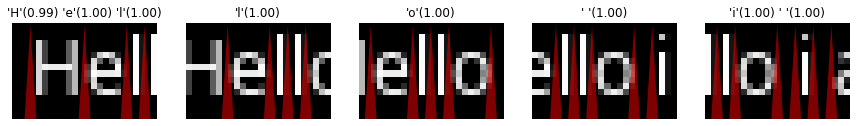

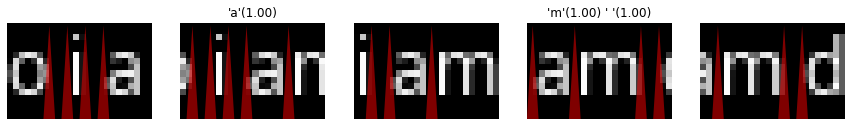

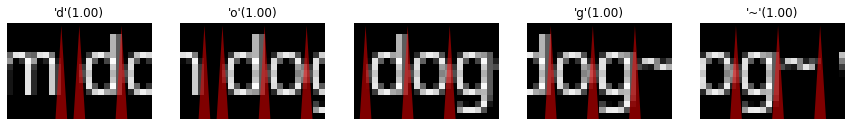

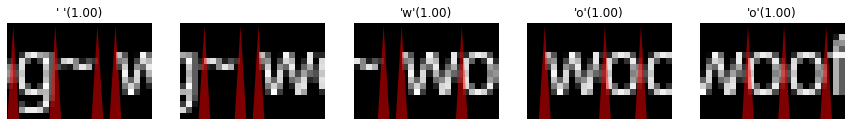

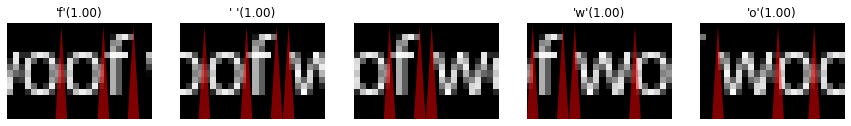

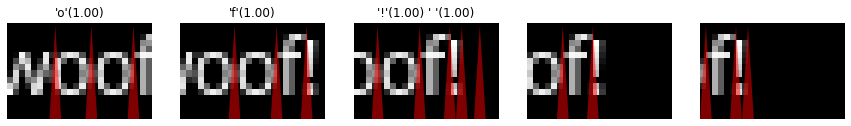

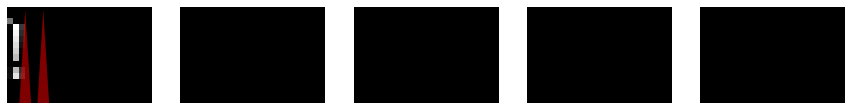

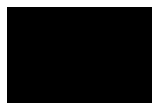

out: Hello i am dog~ woof woof! 


In [16]:
test('Hello i am dog~ woof woof!',verbose=True)

txt: Olly is a noob


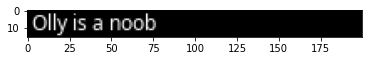

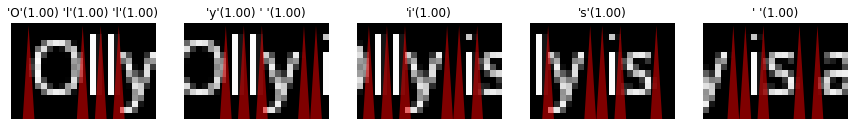

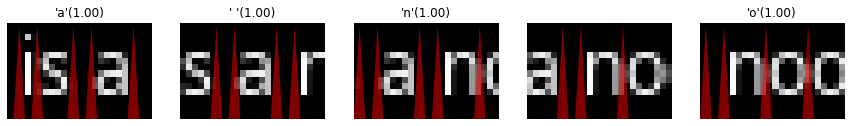

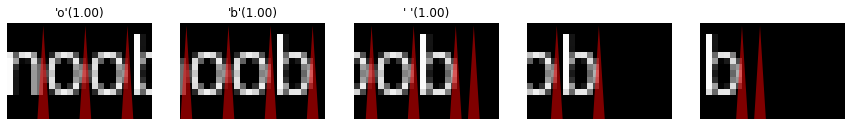

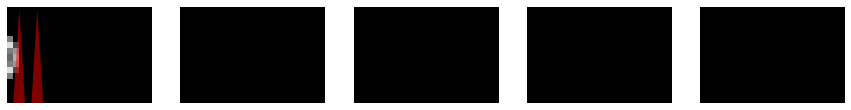

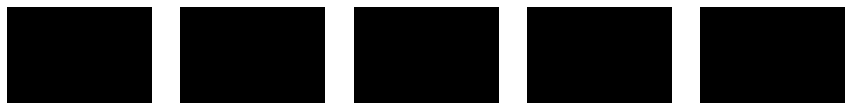

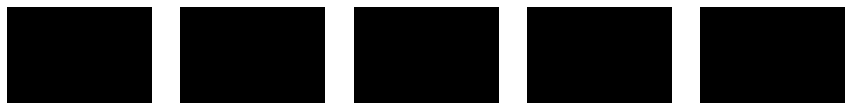

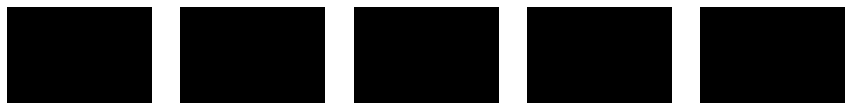

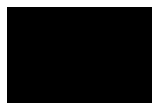

out: Olly is a noob 


In [17]:
test('Olly is a noob',verbose=True)

txt: Greetings, Humans from Earth!


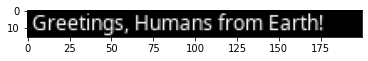

out: Greetings, Humans from Earth! 


In [22]:
test('Greetings, Humans from Earth!')

txt: 867-5309, but what area code???


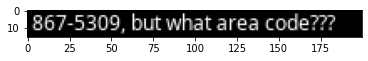

out: 867-5309, but what area code??? 


In [19]:
test('867-5309, but what area code???')

txt: GE price is 413259134637825637


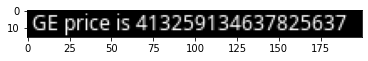

out: GE price is 41325934637825637


In [20]:
test('GE price is 413259134637825637')

txt: lost? https://lmgtfy.com/sendhelp


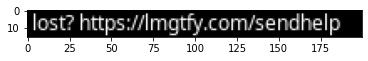

out: lost? https://lmgtfy.com/sendhelp 


In [25]:
test('lost? https://lmgtfy.com/sendhelp')